In [1]:
# update data
!rm -rf COVID-19
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 14547 (delta 14), reused 28 (delta 9), pack-reused 14512
Receiving objects: 100% (14547/14547), 46.89 MiB | 2.56 MiB/s, done.
Resolving deltas: 100% (6946/6946), done.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

In [30]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [103]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,36,50,50,83,93,99,117,129,149,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,"Oakland, MI",US,42.5922,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
402,"Wayne, MI",US,42.2791,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,NaN,Cuba,22.0000,-80.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [85]:
def __split_data(df, nation):

    idx_start = 4

    df_n = df[df['Country/Region']==nation]
    
    n = df_n.shape[0]
    
    X = []
    y = []
    
    for i in range(0,n):
    
        X_t = np.asarray([datetime.strptime(col, '%m/%d/%y').timestamp() for col in df.columns[idx_start:]])
        y_t = df_n.values[i][idx_start:]

        idx = 0
        ii = [ i for i,y in enumerate(y_t) if y<100]
        if len(ii)>0:
            idx = max( ii )

        X_t = X_t[idx:]
        y_t = y_t[idx:]
        
        first_day = min(X_t)

        # renoramlize
        SEC_PER_DAY=24*60*60
        X_t = np.asarray([ (x - first_day)/SEC_PER_DAY for x in X_t])
      
        
        X.append(X_t)
        y.append(y_t)

    return np.asarray(X), np.asarray(y), df_n['Province/State'].values

In [86]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

def __build_model(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                      ('linear', ElasticNet(fit_intercept=False, max_iter=10000))])

    return model

def __evaluate_model(X_train, y_train, model):
      
    # predicting on training data-set
    y_train_predicted = model.predict(X_train)
    
    
    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)
    mape = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100


    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("MAPE score of training set is {}".format(mape))

    return mape, rmse_train, r2_train

In [99]:
def predict_and_plot(df, nation, next_days, color):
    
    DEGREE=4

    X_train_l, y_train_l, provinces = __split_data(df, nation)

    n = X_train_l.shape[0]
    

    for i, p in enumerate(provinces):
        
        X_train = X_train_l[i]
        y_train = y_train_l[i]

        last_day = max(X_train)
        
        model = __build_model(DEGREE)
        
        # fit the transformed features to Linear Regression
        model.fit(X_train.reshape(-1, 1), y_train)
        
        mape, _,_ = __evaluate_model(X_train.reshape(-1, 1), y_train, model)
        
        if str(p)=='nan':
            p='all'
        else:
            p = str(p)
        
        plt.plot(X_train, y_train,'*', label=nation + ' ' + p + ' actual',c=color, linewidth=3.0)
    
        X_test = np.asarray([ i +last_day for i in range(0,next_days)])

        # predicting on test data-set
        y_test_predict = model.predict(X_test.reshape(-1, 1))
        
        
        model = __build_model(DEGREE)
        model.fit(X_train.reshape(-1, 1), y_train)
        y_test_predict_u = model.predict(X_test.reshape(-1, 1))
        
        model = __build_model(DEGREE+1)
        model.fit(X_train.reshape(-1, 1), y_train)
        y_test_predict_l = model.predict(X_test.reshape(-1, 1))
        
        y_test_predict = y_test_predict_u/2 + y_test_predict_l/2
        
        #y_test_predict_l, y_test_predict_u = y_test_predict - y_test_predict*mape/200, y_test_predict + y_test_predict*mape/200
        
        # show predicted data
        plt.plot(X_test, y_test_predict,':',c=color, linewidth=3.0)
        plt.fill_between(X_test, y_test_predict_l, y_test_predict_u, color=color, alpha=0.3, label= nation + ' predicted')

--
 Italy
RMSE of training set is 320.6502239158457
R2 score of training set is 0.9938633911588799
MAPE score of training set is 11.484214482538361
--
 France
RMSE of training set is 97.16508693005046
R2 score of training set is 0.9841146065599686
MAPE score of training set is 19.570566090408544
RMSE of training set is 1.0
R2 score of training set is nan
MAPE score of training set is 50.0
RMSE of training set is 0.6666666666666667
R2 score of training set is nan
MAPE score of training set is 66.66666666666667
--
 Spain
RMSE of training set is 124.44725639415024
R2 score of training set is 0.9752471269045608
MAPE score of training set is 26.160238841937684
--
 Norway
RMSE of training set is 43.234198134994216
R2 score of training set is 0.9616953215541265
MAPE score of training set is 24.413970414856532
--
 Germany


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1073399.5225027367, tolerance: 64880.366
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1073399.5225027367, tolerance: 64880.366
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 909464.0819289624, tolerance: 64880.366
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

RMSE of training set is 55.10435746971314
R2 score of training set is 0.9930051900446718
MAPE score of training set is 16.601054681625023
--
 Japan
RMSE of training set is 29.808630893160327
R2 score of training set is 0.9693244358449474
MAPE score of training set is 14.055070656347175


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17248.770259873043, tolerance: 1402.1080000000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22728.332151537477, tolerance: 1402.1080000000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14422.00194265242, tolerance: 282.3988
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

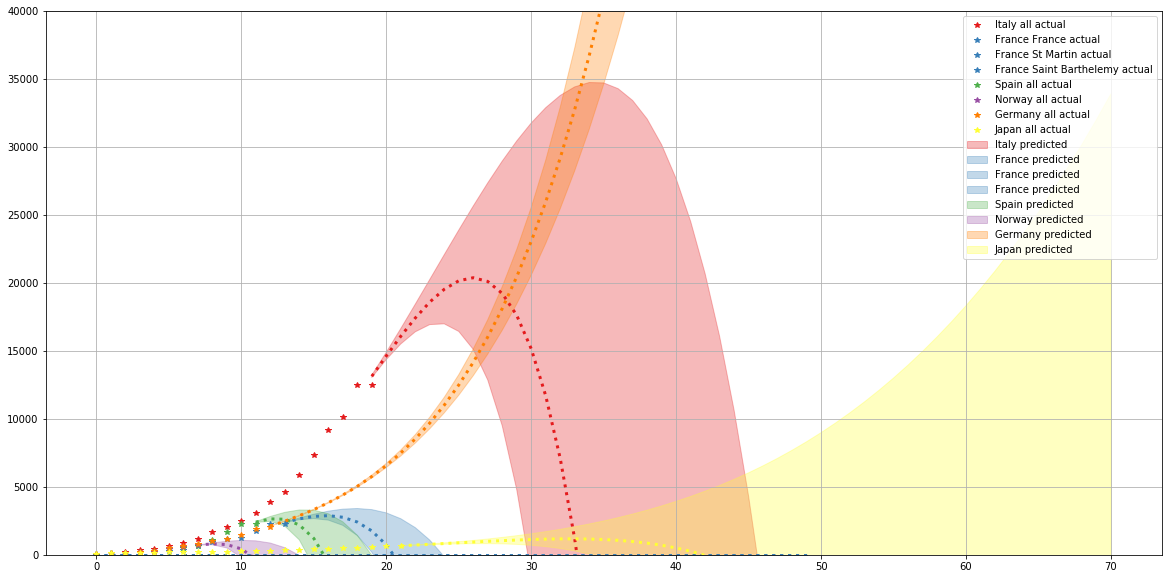

In [108]:
from matplotlib.cm import get_cmap

name = "Set1"
cmap = get_cmap(name)
COLORS =  cmap.colors


def predict_and_plot_all(df, nations, next_days):
    plt.figure(figsize=(20,10))
    for i,nation in enumerate(nations):
        print("--\n",nation)
        predict_and_plot(df, nation, next_days, color = COLORS[i])
    
    plt.ylim(0, 40000) 
    plt.legend()
    plt.grid()
    plt.show()
    
nations=['Italy', 'France',  'Spain','Norway', 'Germany', 'Japan']
predict_and_plot_all(df, nations, 50)